# Imports

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
from derivative import dxdt

In [62]:
# Abre el archivo en modo lectura
with open('Mx_1x10/AUS.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))

years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)

In [65]:
array = np.zeros((10 , 90))

for i in range(0,np.abs(years[0]-years[-1])):
    adicional = 111*i
    rango = [0+adicional,90+adicional]
    data = totals[rango[0]:rango[-1]]

    array[i] = data


TypeError: unsupported operand type(s) for -: 'numpy.str_' and 'numpy.str_'

In [58]:
column_means = np.mean(array, axis=0)


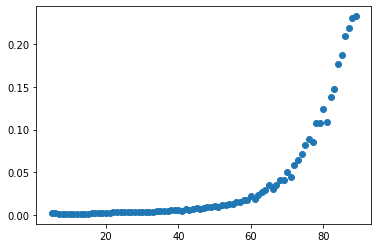

In [77]:
plt.scatter(ages[5:90], totals[5:90])

In [83]:
from scipy.interpolate import CubicSpline

interpolacion = CubicSpline(ages[5:90], totals[5:90])

In [110]:
edad = np.linspace(5,90,100)

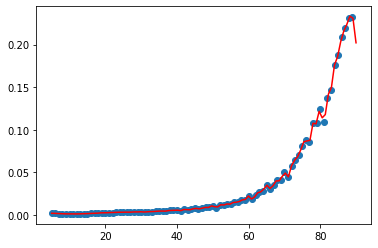

In [111]:
plt.scatter(ages[5:90], totals[5:90])
plt.plot(edad, interpolacion(edad), color = "red")

In [112]:
datos = interpolacion(edad)
derivative_process = dxdt(datos, edad, kind="finite_difference", k=3)
beta_values = derivative_process/datos
R_values = datos/np.e**(beta_values*edad)


In [113]:
edad

array([ 5.        ,  5.85858586,  6.71717172,  7.57575758,  8.43434343,
        9.29292929, 10.15151515, 11.01010101, 11.86868687, 12.72727273,
       13.58585859, 14.44444444, 15.3030303 , 16.16161616, 17.02020202,
       17.87878788, 18.73737374, 19.5959596 , 20.45454545, 21.31313131,
       22.17171717, 23.03030303, 23.88888889, 24.74747475, 25.60606061,
       26.46464646, 27.32323232, 28.18181818, 29.04040404, 29.8989899 ,
       30.75757576, 31.61616162, 32.47474747, 33.33333333, 34.19191919,
       35.05050505, 35.90909091, 36.76767677, 37.62626263, 38.48484848,
       39.34343434, 40.2020202 , 41.06060606, 41.91919192, 42.77777778,
       43.63636364, 44.49494949, 45.35353535, 46.21212121, 47.07070707,
       47.92929293, 48.78787879, 49.64646465, 50.50505051, 51.36363636,
       52.22222222, 53.08080808, 53.93939394, 54.7979798 , 55.65656566,
       56.51515152, 57.37373737, 58.23232323, 59.09090909, 59.94949495,
       60.80808081, 61.66666667, 62.52525253, 63.38383838, 64.24

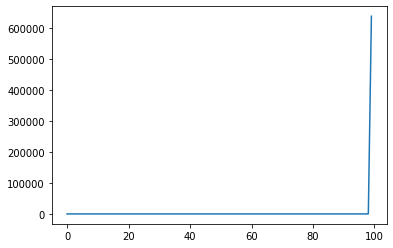

In [114]:
plt.plot(R_values[0:20000])

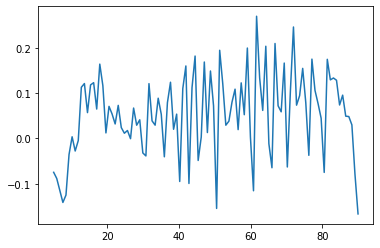

In [115]:
plt.plot(edad, beta_values)